In [21]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from snorkel.labeling import LabelModel, MajorityLabelVoter, RandomVoter
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from multiprocessing import Process

# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [2]:
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

In [3]:
# df = pd.read_csv("../../data/interim/address_train_data.csv", index_col='id')
df = pd.read_csv("../../data/interim/address_without_country_info.csv", index_col='id')

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

## Remove numbers from text

In [4]:
df['clean_address'] = df['address'].replace('\d+', '', regex=True)

## Balance dataset by force

In [5]:
t = df[df.label == True]
f = df[df.label == False]
small_f = f.iloc[np.random.randint(0, len(f), len(t)+1000)]
df_balanced = pd.concat([small_f, t])
df_balanced['label'].value_counts()

0    3000
1    2000
Name: label, dtype: int64

In [6]:
tfv = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,3), use_idf=False)

In [7]:
X_raw = tfv.fit_transform(df_balanced['clean_address']).toarray()
y_raw = df_balanced['label'].values
# X_raw.shape

In [8]:
def random_sampling(classifier, X_pool, n_instances):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), n_instances)
    return query_idx, X_pool[query_idx]

In [9]:
def random_labels(y, fraction_of_random_labels=0.10, cardinality=3):
    mask = np.random.rand(*y.shape) < fraction_of_random_labels
    r = np.random.randint(0, cardinality, size = y.shape)
    y[mask] = r[mask]   
    return y

def fake_multi_user_labeling(y, n_labelers, only_zeroes_idx, fraction_of_random_labels=0.10, cardinality=None):
    y = np.tile(y, (n_labelers, 1)).transpose()
    y = random_labels(y, fraction_of_random_labels, cardinality)
    if only_zeroes_idx is not None:
        y[:,only_zeroes_idx] = 0
    return(y)

In [22]:
def run_labeler(learner, 
                X_pool, y_pool, 
                X_test, y_test, 
                n_queries=10, 
                use_snorkel=False):
    
    if use_snorkel:
        label_model = LabelModel(cardinality=3, verbose=True)
    else:
        majority_voter = MajorityLabelVoter(cardinality=2)
    
    performance_history = [learner.score(X_test, y_test)]
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=0, acc=performance_history[0]))
    
    for index in range(n_queries):
        query_index, query_instance = learner.query(X_pool)

        # Teach our ActiveLearner model the record it has requested.
        X, y = X_pool[query_index], y_pool[query_index]
        y = fake_multi_user_labeling(y, n_labelers = 3, only_zeroes_idx = 0, cardinality=2)

        if use_snorkel:
            label_model.fit(L_train=y, n_epochs=1000, lr=0.001, log_freq=100, seed=123)        
            preds_queried = label_model.predict(L=y)
        else:
            preds_queried = majority_voter.predict(y)

        learner.teach(X=X, y=preds_queried) #, only_new=True)

        # Remove the queried instance from the unlabeled pool.
        X_pool = np.delete(X_pool, query_index, axis=0)
        y_pool = np.delete(y_pool, query_index)

        # Calculate and report our model's accuracy.
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

        # Save our model's performance for plotting.
        performance_history.append(model_accuracy)
    
    return performance_history

performance_hist = []
N_QUERIES = 10
BATCH_SIZE = 30
INITIAL_BATCH_SIZE = 40

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE_SEED)

get_estimator = lambda: LogisticRegression(n_jobs=-1, solver='lbfgs',
                                           random_state=RANDOM_STATE_SEED)

get_active_learner = lambda query_strategy: ActiveLearner(estimator=get_estimator(),
                                                          X_training=X, 
                                                          y_training=y,
                                                          query_strategy=query_strategy)

for i, (train_index, test_index) in enumerate(kf.split(X_raw, y_raw)):
    print("=" * 30 + F"\nExperimenting with Fold number {i+1}")
    
    X_train, y_train = X_raw[train_index], y_raw[train_index]
    X_test, y_test = X_raw[test_index], y_raw[test_index]
    
    # Isolate our examples for our labeled dataset.
    n_labeled_examples = X_train.shape[0]
    training_indices = np.random.choice(n_labeled_examples, size=INITIAL_BATCH_SIZE, replace=False)

    # Initial batch
    X = X_train[training_indices]
    y = y_train[training_indices]

    # Isolate the non-training examples we'll be querying.
    X_pool = np.delete(X_train, training_indices, axis=0)
    # X_pool = delete_rows_csr(X_raw, training_indices)
    y_pool = np.delete(y_train, training_indices, axis=0)
    
    
    # Specify our active learning model.
    rnd_learner = get_active_learner(partial(random_sampling, n_instances=BATCH_SIZE))
    # Specify our active learning model.
    al_learner = get_active_learner(partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE))
    al_learner_no_snorkel = get_active_learner(partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE))

    performance_hist.append({
        'rnd_lr': run_labeler(rnd_learner, X_pool, y_pool, X_test, y_test, n_queries=N_QUERIES, use_snorkel=False),
        'al_lr_snorkel': run_labeler(al_learner, X_pool, y_pool, X_test, y_test, n_queries=N_QUERIES, use_snorkel=True),
        'al_lr': run_labeler(al_learner_no_snorkel, X_pool, y_pool, X_test, y_test, n_queries=N_QUERIES, use_snorkel=False)
    })

Experimenting with Fold number 1
Accuracy after query 0: 0.7700
Accuracy after query 1: 0.8410
Accuracy after query 2: 0.8480
Accuracy after query 3: 0.8260
Accuracy after query 4: 0.8410
Accuracy after query 5: 0.8480
Accuracy after query 6: 0.8570
Accuracy after query 7: 0.8640
Accuracy after query 8: 0.8750
Accuracy after query 9: 0.8790
Accuracy after query 10: 0.8810
Accuracy after query 0: 0.7700
Accuracy after query 1: 0.5400
Accuracy after query 2: 0.8870
Accuracy after query 3: 0.9390
Accuracy after query 4: 0.9480
Accuracy after query 5: 0.9490
Accuracy after query 6: 0.9690
Accuracy after query 7: 0.9740
Accuracy after query 8: 0.9550
Accuracy after query 9: 0.9710
Accuracy after query 10: 0.9770
Accuracy after query 0: 0.7700
Accuracy after query 1: 0.9010
Accuracy after query 2: 0.4540
Accuracy after query 3: 0.9290
Accuracy after query 4: 0.9450
Accuracy after query 5: 0.9350
Accuracy after query 6: 0.9480
Accuracy after query 7: 0.9560
Accuracy after query 8: 0.9610
Accu

In [23]:
results = pd.DataFrame(performance_hist)
results.to_csv('../../data/interim/results_log_reg.csv')
results = {col: results[col].apply(lambda x: pd.Series(x)) for col in results.columns}    

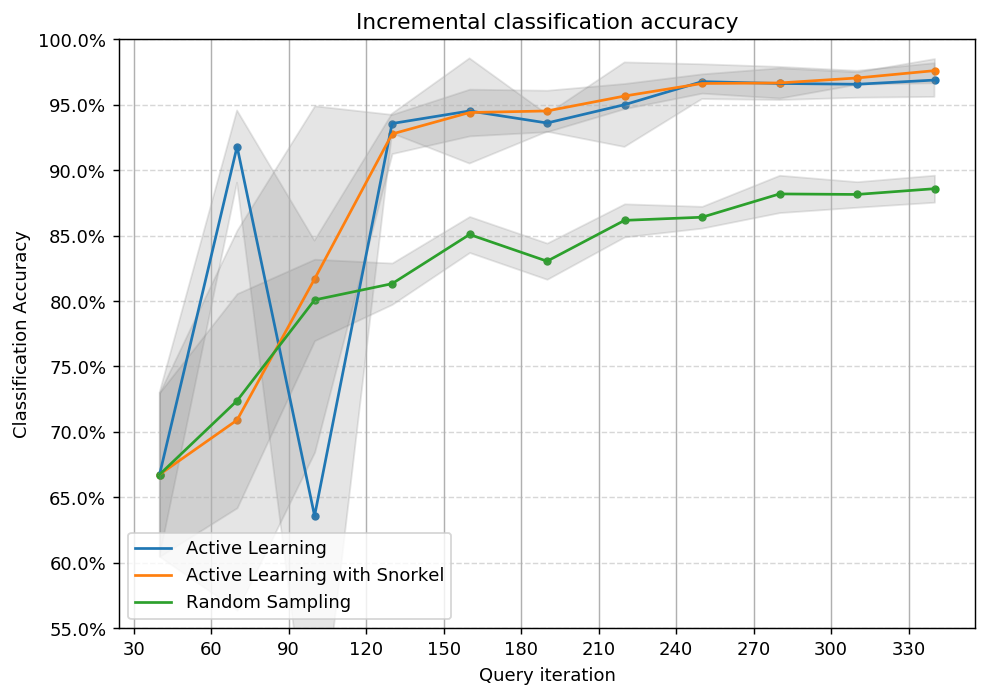

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

labels = {'rnd_lr': 'Random Sampling', 
          'al_lr_snorkel': 'Active Learning with Snorkel',
          'al_lr': 'Active Learning'}

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

x = np.array([INITIAL_BATCH_SIZE] * (N_QUERIES + 1))
x = x + np.array(list(range(N_QUERIES+1))) * BATCH_SIZE


for col in results.keys():
    mean = results[col].mean()
    std = results[col].std()
    
    ax.plot(x, mean, label=labels[col])
    ax.scatter(x, mean, s=13)
    
#     plt.errorbar(x, mean, yerr=std, label=labels[col])

    plt.fill_between(x, mean-std, mean+std, color='gray', alpha=0.2)

plt.legend(loc='lower left')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0.55, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig('../../data/results/img_results.png')
plt.show()

In [26]:
results['al_lr']

,0,1,2,3,4,5,6,7,8,9,10
0,0.770,0.901,0.454,0.929,0.945,0.935,0.948,0.956,0.961,0.957,0.968
1,0.653,0.926,0.462,0.937,0.974,0.945,0.986,0.984,0.985,0.982,0.983
2,0.667,0.950,0.538,0.932,0.969,0.940,0.961,0.977,0.973,0.969,0.972
3,0.600,0.880,0.837,0.948,0.962,0.928,0.898,0.968,0.958,0.958,0.948
4,0.647,0.933,0.888,0.932,0.876,0.932,0.957,0.953,0.954,0.962,0.973
